# Read time-dependent transcriptome data from Aouefa

#### Read Excel sheet:

In [34]:
import pandas as pd
import csv
import cPickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import collections

%matplotlib inline

from pygenome import sg

In [59]:
phase_lengths = collections.OrderedDict([('early G1', 27.2), ('late G1', 33.7), ('S', 20.5), ('G2', 21.4), ('P/M', 9.8), 
                                         ('Ana', 10.4), ('T/C', 4.1)])
sum(phase_lengths.values())

127.10000000000001

In [53]:
phase_lengths.values()

[27.2, 33.7, 20.5, 21.4, 9.8, 10.4, 4.1]

Note that these are ordered.

In [3]:
mrna_file = '../data/Sup_PivotTable_RNA_forPubli_AllGenes.xlsx'

In [4]:
df = {}
df_mult = {}
df_means = {}

In [5]:
df['SIC1'] = pd.read_excel(mrna_file, sheetname='SIC1', skiprows=1, skipfooter=251, parse_cols='A, C:I')
df['SIC1'].head()

,# RNA/cell,early G1,late G1,S,G2,P/M,Ana,T/C
0,0,22,24,22,24,6,1,0
1,1,35,53,41,45,22,1,0
2,2,48,74,54,36,20,10,0
3,3,30,52,22,19,10,6,0
4,4,10,19,9,10,6,4,0


In [6]:
df['CLN2'] = pd.read_excel(mrna_file, sheetname='CLN2', skiprows=1, skipfooter=260, parse_cols='A, C:I')
df['CLN2'].head()

,# RNA/cell,early G1,late G1,S,G2,P/M,Ana,T/C
0,0,123,15,38,105,55,35,11
1,1,27,8,22,37,12,23,6
2,2,11,11,9,20,6,3,3
3,3,12,7,12,4,1,2,1
4,4,10,2,2,1,0,2,0


In [7]:
df['CLB5'] = pd.read_excel(mrna_file, sheetname='CLB5', skiprows=1, skipfooter=89, parse_cols='A, C:I')
df['CLB5'].head()

,# RNA/cell,early G1,late G1,S,G2,P/M,Ana,T/C
0,0,69,35,55,94,43,45,6
1,1,46,47,47,31,19,26,10
2,2,27,27,27,12,8,5,1
3,3,10,25,22,5,0,3,2
4,4,4,32,12,3,0,4,3


#### Calculate means per cell cycle phase:

In [76]:
df_mult['SIC1'] = df['SIC1'].mul(df['SIC1']['# RNA/cell'], axis=0).drop('# RNA/cell', axis=1)
df_means['SIC1'] = df_mult['SIC1'].sum(axis=0) / df['SIC1'].sum(axis=0).drop('# RNA/cell')
df_means['SIC1']

early G1     4.084577
late G1      3.449275
S            2.343195
G2           2.055944
P/M          2.101449
Ana         14.231884
T/C         24.933333
dtype: float64

In [77]:
df_mult['CLN2'] = df['CLN2'].mul(df['CLN2']['# RNA/cell'], axis=0).drop('# RNA/cell', axis=1)
df_means['CLN2'] = df_mult['CLN2'].sum(axis=0) / df['CLN2'].sum(axis=0).drop('# RNA/cell')
df_means['CLN2']

early G1     3.254237
late G1     18.021277
S            5.644628
G2           0.666667
P/M          0.364865
Ana          1.119403
T/C          2.592593
dtype: float64

In [78]:
df_mult['CLB5'] = df['CLB5'].mul(df['CLB5']['# RNA/cell'], axis=0).drop('# RNA/cell', axis=1)
df_means['CLB5'] = df_mult['CLB5'].sum(axis=0) / df['CLB5'].sum(axis=0).drop('# RNA/cell')
df_means['CLB5']

early G1    1.321429
late G1     3.783784
S           1.826816
G2          0.565517
P/M         0.619718
Ana         0.977273
T/C         2.793103
dtype: float64

We know have absolute abundance values of three transcript types during the whole cell cycle. The next step will be to combine this information with the relative abundance data.

#### Discover corresponding genes in Lotte transcriptome:

In [126]:
# ['YLR079W']  # Sic1
# ['YPL256C']  # Cln2
# ['YPR120C']  # Clb5

In [11]:
filename = "../data/nostress_WT_R1.csv"
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))

transcripts = pd.DataFrame()

with open(filename, mode='r') as infile:
    reader = csv.reader(infile, delimiter=',')
    times = [int(float(val)) for val in reader.next()[1:]]
    ntimes = len(times)
    for rows in reader:
        try:
            # convert to systematic names
            colname = rows[0] if rows[0] in orf_genomic_dict else sg.systematic_name(rows[0])
            transcript_values = pd.Series(data=[float(rows[i]) for i in range(2, ntimes + 1)])  # the time point -1 is not needed
            transcripts[colname] = transcript_values
        except:
            pass

In [12]:
transcripts.index = times[1:]
print len(transcripts.columns)

5795


Create "normalized" transcriptome (containing percentages at each point in time):

In [13]:
transcripts_norm = (transcripts.T / transcripts.sum(axis=1)).T

Plot cell cycle genes in Lotte data:

In [23]:
sic1 = transcripts_norm['YLR079W']
cln2 = transcripts_norm['YPL256C']
clb5 = transcripts_norm['YPR120C']

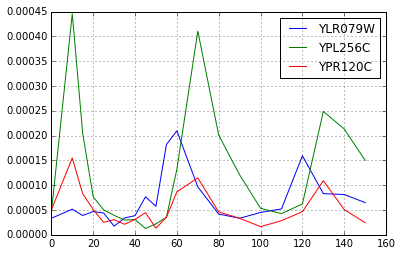

In [24]:
sic1.plot(legend=True)
cln2.plot()
clb5.plot()

We assume that this data set has a shortened (early) G1 phase.

Plot Aouefa's data for comparison:

In [87]:
df_means['SIC1'].index = np.cumsum(phase_lengths.values()) - np.array(phase_lengths.values()) / 2.
df_means['CLN2'].index = np.cumsum(phase_lengths.values()) - np.array(phase_lengths.values()) / 2.
df_means['CLB5'].index = np.cumsum(phase_lengths.values()) - np.array(phase_lengths.values()) / 2.

In [80]:
means = pd.DataFrame(df_means)

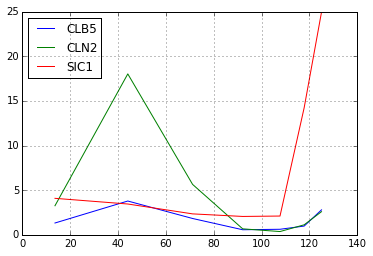

In [86]:
means.plot()

The data look qualitatively similar but with a longer G1 phase.

Next steps: 

* put Lotte and Aouefa data on same time scale
* calculate averages per cell cycle phase
* calculate multipliers per cell cycle phase for each cell cycle gene
* find "best" multiplier (e.g. average of the three multipliers)
* use multipliers to calculate absolute transcriptome

In [85]:
means=means.drop('t', axis = 1)